In [20]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import os
import gc

from shared.utils import *
from shared.kaggle_path import *

from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Image Data

In [26]:
filepath = []
label = []

i = 0
for classes in os.listdir(TRAIN_IMAGE_PATH):
    for file in os.listdir(os.path.join(TRAIN_IMAGE_PATH, classes)):
        path = os.path.join(TRAIN_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

train_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(train_df.shape)
print(train_df['label'].unique())
train_df.head()

(33228, 2)
['angry' 'happy' 'sad' 'fear' 'neutral' 'disgust' 'surprise']


,filepath,label
0,/kaggle/working/dataset/new_data/train/angry/a...,angry
1,/kaggle/working/dataset/new_data/train/angry/T...,angry
2,/kaggle/working/dataset/new_data/train/angry/T...,angry
3,/kaggle/working/dataset/new_data/train/angry/T...,angry
4,/kaggle/working/dataset/new_data/train/angry/a...,angry


In [27]:
filepath = []
label = []

i = 0
for classes in os.listdir(TEST_IMAGE_PATH):
    for file in os.listdir(os.path.join(TEST_IMAGE_PATH, classes)):
        path = os.path.join(TEST_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

img_test_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(img_test_df.shape)
print(img_test_df['label'].unique())
img_test_df.head()

(7311, 2)
['angry' 'happy' 'sad' 'fear' 'neutral' 'disgust' 'surprise']


,filepath,label
0,/kaggle/working/dataset/new_data/test/angry/Pu...,angry
1,/kaggle/working/dataset/new_data/test/angry/Pu...,angry
2,/kaggle/working/dataset/new_data/test/angry/Pr...,angry
3,/kaggle/working/dataset/new_data/test/angry/Pr...,angry
4,/kaggle/working/dataset/new_data/test/angry/Pu...,angry


In [28]:
le = LabelEncoder()
le.fit(train_df['label'])
train_df['label_encoded'] = le.transform(train_df['label'])
img_test_df['label_encoded'] = le.transform(img_test_df['label'])

In [29]:
with tf.device('/GPU:0'):
    train_df['data'] = train_df['filepath'].apply(lambda x: preprocess_image(x, (100, 100)))
    img_test_df['data'] = img_test_df['filepath'].apply(lambda x: preprocess_image(x, (100, 100)))

train_df.shape

(33228, 4)

In [30]:
x_img = np.stack(train_df['data'].values)
y_img = train_df['label_encoded'].values

x_img_test = np.stack(img_test_df['data'].values)
y_img_test = img_test_df['label_encoded'].values

del train_df, img_test_df

x_img_train, x_img_val, y_img_train, y_img_val = train_test_split(x_img, y_img, test_size=0.25, random_state=102, shuffle=True, stratify=y_img)
del x_img, y_img

# Modeling
## Model Image

In [31]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=tf.keras.layers.Input(shape=(100, 100, 3)),
)

# base_model.trainable = False
# for layer in base_model.layers:
#     layer.trainable = False

In [32]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

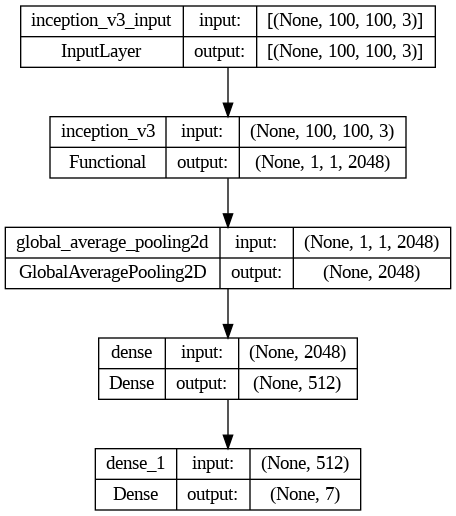

In [33]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [34]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    mode='min',
    # start_from_epoch=2,
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('model', 'best_model.keras'),
    verbose=2,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.2,
                                                    min_lr=1e-6,
                                                    patience=3,
                                                    mode='min'
                                                    )

In [35]:
history = model.fit(
    x_img_train,
    y_img_train,
    validation_data=(x_img_val, y_img_val),
    # callbacks=[early, checkpoint, lr_scheduler],
    epochs=100,
    verbose=2,
    batch_size=64,
    steps_per_epoch=len(x_img_train) // 64,
    validation_steps=len(x_img_val) // 64,
)


Epoch 1/100


I0000 00:00:1746778336.013795     294 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


415/415 - 50s - loss: 11.1860 - accuracy: 0.1776 - val_loss: 7.1102 - val_accuracy: 0.1992 - 50s/epoch - 121ms/step
Epoch 2/100
415/415 - 37s - loss: 6.4593 - accuracy: 0.2074 - val_loss: 5.9692 - val_accuracy: 0.1968 - 37s/epoch - 89ms/step
Epoch 3/100
415/415 - 27s - loss: 5.3252 - accuracy: 0.2259 - val_loss: 6.2275 - val_accuracy: 0.2113 - 27s/epoch - 65ms/step
Epoch 4/100
415/415 - 27s - loss: 4.7064 - accuracy: 0.2350 - val_loss: 4.4397 - val_accuracy: 0.2339 - 27s/epoch - 66ms/step
Epoch 5/100
415/415 - 27s - loss: 4.1985 - accuracy: 0.2478 - val_loss: 4.4831 - val_accuracy: 0.2327 - 27s/epoch - 65ms/step
Epoch 6/100
415/415 - 27s - loss: 3.9855 - accuracy: 0.2536 - val_loss: 4.8220 - val_accuracy: 0.2151 - 27s/epoch - 66ms/step
Epoch 7/100
415/415 - 27s - loss: 3.7324 - accuracy: 0.2621 - val_loss: 4.1248 - val_accuracy: 0.2365 - 27s/epoch - 66ms/step
Epoch 8/100
415/415 - 27s - loss: 3.6579 - accuracy: 0.2679 - val_loss: 4.9087 - val_accuracy: 0.2086 - 27s/epoch - 66ms/step
Ep

In [36]:
def plot_and_save(metric_name, history, ylabel, filename):
    plt.figure()
    plt.plot(history.history[metric_name], label=f'Train {ylabel}')
    if f'val_{metric_name}' in history.history:
        plt.plot(history.history[f'val_{metric_name}'], label=f'Val {ylabel}')
    plt.title(f'{ylabel} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

In [37]:
plot_and_save('loss', history, 'Loss', 'vgg19-image_loss_plot.png')
plot_and_save('accuracy', history, 'Image Classification Accuracy', 'vgg19-image_class_accuracy_plot.png')

In [38]:
predictions = model.predict(x_img_test)
predictions = np.argmax(predictions, axis=1)

229/229 [==============================] - 9s 21ms/step


In [39]:
classes = [x for x in os.listdir(TRAIN_IMAGE_PATH)]
print(classes)

['angry', 'happy', 'sad', 'fear', 'neutral', 'disgust', 'surprise']


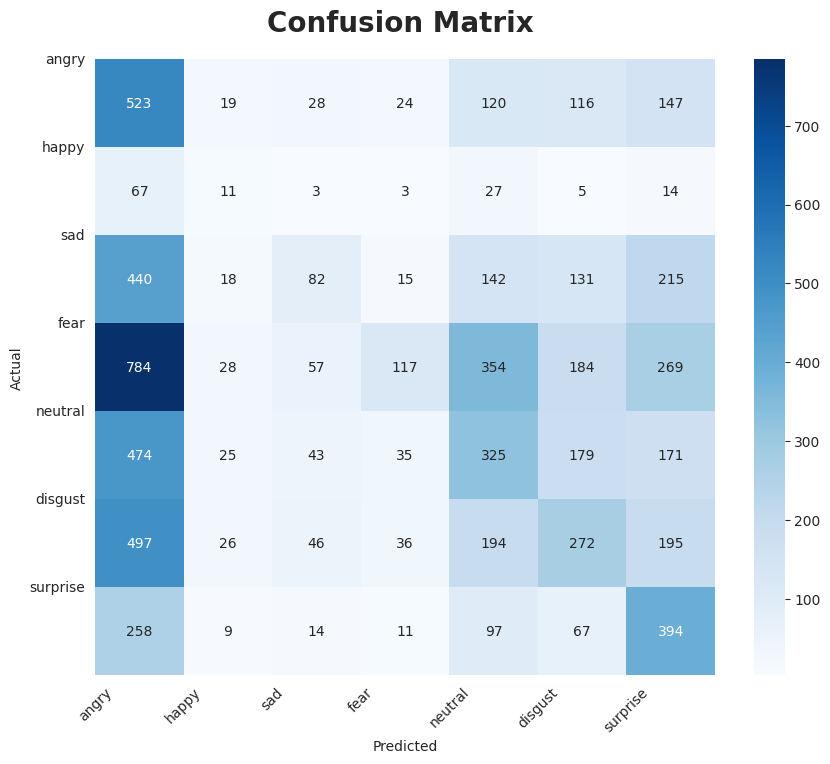

In [40]:
cm = confusion_matrix(y_img_test, predictions)

plt.figure(figsize=(10, 8))  # Set the figure size if needed
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix VGG19-IMG', pad=20, fontsize=20, fontweight="bold")
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Set ticks for the x and y axes using class names
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=range(len(classes)), labels=classes, rotation=0)
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Eval Result
## Accuracy
Accuracy = (Sum of diagonal elements) / (Sum of all elements) <br>
= (442 + 51 + 459 + 1255 + 673 + 655 + 622) / Sum of all values <br>
= 4157 / 7331 <br>
= 0.5670 or 56.70% <br>

## Class-wise Metrics
### Angry
- Precision = TP / (TP + FP) = 442 / (442 + 24 + 121 + 98 + 123 + 132 + 26) = 442 / 966 = 0.4576 or 45.76%
- Recall = TP / (TP + FN) = 442 / (442 + 16 + 161 + 50 + 105 + 183 + 20) = 442 / 977 = 0.4524 or 45.24%
- F1-score = 2 × (Precision × Recall) / (Precision + Recall) = 2 × (0.4576 × 0.4524) / (0.4576 + 0.4524) = 0.4550 or 45.50%

### Disgust
- Precision = 51 / (51 + 16 + 7 + 10 + 4 + 12 + 1) = 51 / 101 = 0.5050 or 50.50%
- Recall = 51 / (51 + 24 + 15 + 14 + 6 + 16 + 4) = 51 / 130 = 0.3923 or 39.23%
- F1-score = 2 × (0.5050 × 0.3923) / (0.5050 + 0.3923) = 0.4414 or 44.14%

### Fear
- Precision = 459 / (459 + 161 + 100 + 120 + 186 + 80) = 459 / 1106 = 0.4150 or 41.50%
- Recall = 459 / (459 + 121 + 7 + 39 + 115 + 200 + 102) = 459 / 1043 = 0.4401 or 44.01%
- F1-score = 2 × (0.4150 × 0.4401) / (0.4150 + 0.4401) = 0.4271 or 42.71%

### Happy
- Precision = 1255 / (1255 + 50 + 14 + 39 + 72 + 53 + 45) = 1255 / 1528 = 0.8213 or 82.13%
- Recall = 1255 / (1255 + 98 + 10 + 100 + 147 + 124 + 59) = 1255 / 1793 = 0.6999 or 69.99%
- F1-score = 2 × (0.8213 × 0.6999) / (0.8213 + 0.6999) = 0.7554 or 75.54%

### Neutral
- Precision = 673 / (673 + 105 + 6 + 115 + 147 + 195 + 40) = 673 / 1281 = 0.5254 or 52.54%
- Recall = 673 / (673 + 123 + 4 + 120 + 72 + 227 + 33) = 673 / 1252 = 0.5376 or 53.76%
- F1-score = 2 × (0.5254 × 0.5376) / (0.5254 + 0.5376) = 0.5314 or 53.14%

### Sad
- Precision = 655 / (655 + 183 + 16 + 200 + 124 + 227 + 36) = 655 / 1441 = 0.4546 or 45.46%
- Recall = 655 / (655 + 132 + 12 + 186 + 53 + 195 + 33) = 655 / 1266 = 0.5174 or 51.74%
- F1-score = 2 × (0.4546 × 0.5174) / (0.4546 + 0.5174) = 0.4839 or 48.39%

### Surprise
- Precision = 622 / (622 + 20 + 4 + 102 + 59 + 33 + 33) = 622 / 873 = 0.7125 or 71.25%
- Recall = 622 / (622 + 26 + 1 + 80 + 45 + 40 + 36) = 622 / 850 = 0.7318 or 73.18%
- F1-score = 2 × (0.7125 × 0.7318) / (0.7125 + 0.7318) = 0.7220 or 72.20%

## Macro Average (unweighted)
- Macro Precision = (0.4576 + 0.5050 + 0.4150 + 0.8213 + 0.5254 + 0.4546 + 0.7125) / 7 = 0.5559 or 55.59%
- Macro Recall = (0.4524 + 0.3923 + 0.4401 + 0.6999 + 0.5376 + 0.5174 + 0.7318) / 7 = 0.5388 or 53.88%
- Macro F1-score = (0.4550 + 0.4414 + 0.4271 + 0.7554 + 0.5314 + 0.4839 + 0.7220) / 7 = 0.5452 or 54.52%

## Summary of Results:
- Overall Accuracy: 56.70%
- Macro Precision: 55.59%
- Macro Recall: 53.88%
- Macro F1-score: 54.52%

The model performs best on the "happy" and "surprise" classes, with F1-scores of 75.54% and 72.20% respectively, while struggling more with "fear" (42.71%) and "disgust" (44.14%).

In [ ]:
print(classification_report(y_img_test, predictions))